# Part 1: Overview

The subject of this case study is an investigation into inflection points for a dataset provided on May 8, 2020. That dataset contained daily sales data for several merchants, split between two different panels (PANEL_1 and PANEL_2) and two different transaction types (CREDIT and DEBIT).

The goal for the case study is to write code in Python that will identify inflections points for particular merchants on particular dates within the data, along with some indication as to how we should classify those inflection points. The structure of this document is as follows:

- An overview of the problem.
- Theoretical considerations that we will use to derive a solution along with a step-by-step overview for development of the code to achieve this.
- A final, compact, summarized set of code that will combine all of the previous work done.
- Analysis of the dataset in terms of how many inflection points there are, and how we classify them.
- Final conclusions and some suggestions for future work on this project.


# Part 2: Theoretical Considerations

## What is an "inflection point" and how do we measure it?

To start, we need to come up with a reasonable idea as to what an "inflection" even is in the context of the data. Colloquially, people refer to inflection points as major turning points. If a person kicks a bada habit or starts a family, these can be said to be "inflection points" in that person's life. How does one measure inflection points in the life cycle of a business? Poetics aside, it would be convenient if we could arrive at some quantitative means for discerning inflection points and classifying them.

Fortunately, a framework exists that does precisely this. One may recall hearing about "inflection points" in your high school or college calculus class. In calculus, when we talk about a continuous, differentiable function, an **inflection point** is defined as a point at which the _concavity_ of the function changes. What this means is that the function either goes from being concave to convex, or vice versa. A **concave** function is one in which no line segment joining two points on the graph lies above the graph at any point, while a **convex** function is one in which no line segment joining two points on the graph lies below the graph at any point. Another way to put this is that a convex function "holds water" (think a U-shaped curve like a parabola) while a concave function does not "hold water" (think an n-shaped curve, like the negative absolute value function). 

How do we go about quantifying the concavity of a function? To do this, we use another calculus tool: the derivative. The **derivative** is the rate of change of a function and can be thought of as the slope of a line that is tangent to the curve at the given point. In general, if you have a continuous and differentiable function, $f(x)$, we can determimne the rate of change of the function by means of looking at its first derivative. If the first derivative is positive, it means that the function, at that point, is increasing. If the derivative is negative, it means that the function is decreasing at that point. Finally, if the derivative is 0, it means that the function value is neither increasing, nor decreasing; instead, it is constant. Visually, one can observe the magnitude of the first derivative of a function as the "steepness" of the curve: the steeper it is, the larger is the magntitude of the derivative, and the more dramatic is the rate of change.

The derivative is useful when one wants to find a local maximum or minimum for a function, but alone it will not tell us anything about its concavity. To investigate the concavity, we can take the derivative of the derivative, also known as the **second derivative** of the function. When this value is positive, it means that the function is convex; when it is negative, it means that the function is concave. If the second derivative changes sign from positive to negative or negative to positive, the function is changing its concavity at that point. It is **_this_** that indicates an inflection point.

If we could discover a formula for the derivative of a function, then we could take the first derivative of the sales function and then take the derivative of that in order to ascertain the concavity. From there, we need to look for sign changes in the second derivative. So the first concern is how we will go about calculating the derivative.

By definiton, the derivative is given as:

$\frac{d}{{dx}}f\left( x \right) = \mathop {\lim }\limits_{h \to 0} \frac{{f\left( {x + h } \right) - f\left( x \right)}}{h }$ 

This is known as the **difference quotient**, and it says that the derivative can be found by choosing a small value $h$ and looking at the change in the function when it moves from $x$ to $x+h$. We want to take the limit as $h$ gets smaller and smaller to approximate the derivative.

Of course, in real life we will always be working with some real step size that cannot be made infinitseimally small. In our data set, we have daily data, so it is natural to take the step size to be 1 day. Thus, we use $h$ = 1. Then we can approximate the derivative by taking the _difference_ of the original Sales series. Another question remains, though: Do we take the difference between the value of the function at its current location and that of its value in the next day, or we do the opposite and take the difference between the function and its previous day? Both are "correct" but will potentially yield different results. These are known as the **forward** and **backward** formulas, respectively.

Another way to go, known by us through some numerical analysis, is to use more complex formulas for the numerical approximation of the derivative. These are the **3 point** and **5 point** formulas that can be derived from the Taylor series expansion for the function. The advantage of using these formulas is that for a small step size, $h$, the error becomes smaller. To be thorough, we will use all four of the above formulas for this case study in order to get an idea which are most effective.

So now we need a way to calculate the derivative using these four different methods. Generally, we will take as an input a Pandas dataframe consisting of 2 columns: the date and the corresponding sales. Of course, our function assumes that we have fixed the merchant, the panel, and the payment method, so that we can execute this function and then have some other, outer function deal with iterating through these combinations.

So we have our first bit of code for this case study, which will approximate the derivative, as follows:

In [484]:
import pandas as pd

"""
Function takes in a Pandas dataframe with two columns and appends the following new columns:

-first derivative using the forward series,
-the first derivative using the backward series,
-the first derivative using the three point formula,
-the first derivative using the five point formula.

h is the step size and defaults to 1.
"""
def FirstDerivative(data0,h=1):
    data = data0.copy()
    data["FirstDerivative_Forward"] = data.Sales.diff(periods=-1).divide(h).multiply(-1)
    data["FirstDerivative_Backward"] = data.Sales.diff().divide(h)
    data["ThreePointFormula"] = data.Sales.shift(periods = -1).add(
        data.Sales.shift(periods = 1).multiply(-1)).divide(2*h)
    data["FivePointFormula"] = data.Sales.shift(periods = 2).add(
        data.Sales.shift(periods = 1).multiply(-8)).add(
        data.Sales.shift(periods = -1).multiply(8)).add(
        data.Sales.shift(periods = -2).multiply(-1)).divide(12*h)
    return data.copy()

## Data Integrity Checks

Given this function, we now want to examine the integrity of the data. We start by loading it and checking the statistics to ensure that it is what we expect.

In [485]:
import csv
import numpy as np

fileName = "C:/Users/rg255/Downloads/Inflections.csv"
rawData = pd.read_csv(fileName)
rawData.info()
print("-----------------------------------------------------------------")
print(rawData.head())
print("-----------------------------------------------------------------")
print("The number of merchants is {0}.".format(rawData.Merchant.nunique()))
print("-----------------------------------------------------------------")
print("The number of panels is {0}.".format(rawData.Panel.nunique()))
print("-----------------------------------------------------------------")
print("The number of types is {0}.".format(rawData.Type.nunique()))
print("-----------------------------------------------------------------")
rawData.groupby(["Merchant"]).count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174714 entries, 0 to 174713
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Merchant  174714 non-null  object 
 1   Date      174714 non-null  object 
 2   Panel     174714 non-null  object 
 3   Type      174714 non-null  object 
 4   Sales     174714 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.7+ MB
-----------------------------------------------------------------
   Merchant      Date    Panel    Type     Sales
0  AutoZone  1/1/2015  PANEL_1  CREDIT  13838.77
1  AutoZone  1/1/2015  PANEL_1   DEBIT  75988.04
2  AutoZone  1/2/2015  PANEL_1  CREDIT  21347.54
3  AutoZone  1/2/2015  PANEL_1   DEBIT  84599.99
4  AutoZone  1/3/2015  PANEL_1  CREDIT  23281.26
-----------------------------------------------------------------
The number of merchants is 25.
-----------------------------------------------------------------
The number of panels is 2.
--------

,Date,Panel,Type,Sales
Merchant,,,,
AutoZone,7302,7302,7302,7302
BJ's Ex Fuel,7303,7303,7303,7303
Canada Goose,1847,1847,1847,1847
Dollar General,7303,7303,7303,7303
Domino's Pizza,7304,7304,7304,7304
Kohl's,7304,7304,7304,7304
Lyft,7304,7304,7304,7304
Macy's,7304,7304,7304,7304
Michael Kors,7304,7304,7304,7304


So we can see that there are only two types of panels and types (which is what we expect). There are a total of 25 merchants. The data are supposed to be from 2015 to 2019. So if we do a naive calculation, we would expect:

**Number of rows per merchant = (2 x 2 x 365 x 5) + 4 = 7,304**

Note that we add 4 to account for the fact that there was a leap year that added one day to one of the years (and 1 day would have 4 rows with it). As is clear from our final group by statement above, though, some of the merchants (Tesla, Sherwin Williams, Planet Fitness, Peloton, Dollar General, Canada Goose, Autozone, and BJ's Ex Fuel) do not have the full set of data. Some days appear to be missing. This is not a showstopper, though, since we will be investigating each company separately, but it would be interesting to know why some of the data is missing for these merchants.

Apart from these basic exploratory facts, we can also notice that the date is not properly formatted in the file to allow us to exploit the datetime data type in Pandas. Some days have two characters if they are two-digit numbers, but the one-digit numbers do not have a leading '0'. The same thing happens for some months. Thus, we should write a helper function that will fix these dates and append a new field to the rawData for the FixedDate, which we will use going forward.

In [486]:
#Code that ensures the dates are properly formatted.
def fixDate(x):
    if len(x) == 8:
        return "0" + x[0] + "/" + "0" + x[2] + x[3:]
    elif len(x) == 9 and x.find("/") == 1:
        return "0" + x[0:]
    elif len(x) == 9:
        return x[0:3] + "0" + x[3:]
    else:
        return x

#Add a new field to the dataset that has the proper date format.
rawData["FixedDate"] = pd.to_datetime(rawData.Date.apply(fixDate))
rawData

,Merchant,Date,Panel,Type,Sales,FixedDate
0,AutoZone,1/1/2015,PANEL_1,CREDIT,13838.770000,2015-01-01
1,AutoZone,1/1/2015,PANEL_1,DEBIT,75988.040000,2015-01-01
2,AutoZone,1/2/2015,PANEL_1,CREDIT,21347.540000,2015-01-02
3,AutoZone,1/2/2015,PANEL_1,DEBIT,84599.990000,2015-01-02
4,AutoZone,1/3/2015,PANEL_1,CREDIT,23281.260000,2015-01-03
...,...,...,...,...,...,...
174709,Wix.com,12/29/2019,PANEL_2,DEBIT,1110.925315,2019-12-29
174710,Wix.com,12/30/2019,PANEL_2,CREDIT,11709.298370,2019-12-30
174711,Wix.com,12/30/2019,PANEL_2,DEBIT,1722.840228,2019-12-30
174712,Wix.com,12/31/2019,PANEL_2,CREDIT,17158.065270,2019-12-31


## Dataset Permutations and An Algorithm For Counting Inflection Points

It is clear from the above that for each of the 25 merchants, there are numerous ways to count the number of inflection points. Let's get a count for how many different ways we can do this.

The first factor is the approach that we will use for calculating the derivative. As mentioned in the earlier section, there are 4 approaches: forward, backward, 3point and 5point. Aside from that, there is the fact that the we have options for partitioning the data based on two other fields: Panel and Type. For each of these, there are two values. Thus, for a given merchant, we need to decide which approach to use and then choose a partition scheme. The table below illustrates the available permutations:

| Approach | Partition | Type   | Panel   |
|----------|-----------|--------|---------|
| forward  | panel     | NA     | panel_1 |
| forward  | panel	   | NA     | panel_2 |
| forward  | ttype	   | CREDIT	| NA      |
| forward  | ttype	   | DEBIT	| NA      |
| forward  | all	   | CREDIT	| panel_1 |
| forward  | all	   | CREDIT	| panel_2 |
| forward  | all	   | DEBIT	| panel_1 |
| forward  | all	   | DEBIT	| panel_2 |
| forward  | none	   | NA     | NA      |
| backward | panel	   | NA     | panel_1 |
| backward | panel	   | NA     | panel_2 |
| backward | ttype	   | CREDIT | NA      |
| backward | ttype	   | DEBIT  | NA      |
| backward | all	   | CREDIT | panel_1 |
| backward | all	   | CREDIT | panel_2 |
| backward | all	   | DEBIT  | panel_1 |
| backward | all	   | DEBIT  | panel_2 |
| backward | none	   | NA     | NA      |
| 3point   | panel	   | NA     | panel_1 |
| 3point   | panel	   | NA     | panel_2 |
| 3point   | ttype	   | CREDIT | NA      |
| 3point   | ttype	   | DEBIT  | NA      |
| 3point   | all	   | CREDIT | panel_1 |
| 3point   | all	   | CREDIT | panel_2 |
| 3point   | all	   | DEBIT  | panel_1 |
| 3point   | all	   | DEBIT  | panel_2 |
| 3point   | none	   | NA     | NA      |
| 5point   | panel	   | NA     | panel_1 |
| 5point   | panel	   | NA     | panel_2 |
| 5point   | ttype	   | CREDIT | NA      |
| 5point   | ttype	   | DEBIT  | NA      |
| 5point   | all	   | CREDIT | panel_1 |
| 5point   | all	   | CREDIT | panel_2 |
| 5point   | all	   | DEBIT  | panel_1 |
| 5point   | all	   | DEBIT  | panel_2 |
| 5point   | none	   | NA     | NA      |

This is a total of 36 different permutations. Since there are 25 merchants, we have 25 x 36 = 900 different datasets to consider. We will not be able to consider all 900 in great detail in this case study, but we will be able to produce tools which will enable us to run all 900, in principle, if we want to.

What is needed now is a general algorithm for processing any one of these 36 permutations for any of the 25 merchants in the dataset. Generally, one algorithm that will get the job done is as follows:

- Set data = rawData
- for m in merchants:
    - for p in panels:
        - for t in types:
            - Set V = filter(data,m,p,t)
            - Set D1 = firstDerivative(V)
            - Set D2 = firstDerivative(D1)
            - for d2 in D2:
                - if changedSign(d2):
                    - report d2

Of course, if we are doing a partition method where we are not partitioning by panel or type, then we would short-circuit that loop and set a default value for the factor.

Before we get to the code, we need to consider two additional things. First, what does it mean to "report" an inflection point? It means that we should know when it occurred, for what merchant it occurred, and how "severe" it is. If it was identified in a context where we partitioned the data by panel and/or type, we should also know those values as well. We should also be able to retrieve the sales that occurred on that day and the actual value of the second derivative at that point. Finally, we should know the **streak** for the second derivative. The streak is how long the second derivative kept its sign the same before it changed. This will help us to later classify how severe the changes in concavity were.

Second, we need to remember that there are 4 methods for estimating the derivative (and the corresponding second derivative): the forward equation, the backward equation, the three-point equation, and the five-point equation. We should also give the user the option to use one of these methods to process the data.

When all is said and done, we will want a nice, clean version of the classes needed to implement the above algorithms, including the data ingestion and fix. This is an ambitious project and will require a few classes. Let's create two: one to identify and classify inflection points and another to run the analysis according to whatever the parameters are that the user wants to try. The next section consolidates the code written to load and clean the data, as well as the code needed to implement the classes that we discussed above.

# Part 3: Code Implementation

Below we have the full implementation of the classes Inflection and InflectionAnalysis. The user will only need to instantiate an instance of the latter, which makes use of the former.

In [487]:
import numpy as np
import pandas as pd
import csv

class Inflection:
    """
    A class for storing information about an inflection point. We include the merchant, the date that it occurred, the sales
    value, the panel it came from, the transaction type, the value of the second derivative, and the streak (that is, how
    abrupt it was).
    """
    def __init__(self,m,d,p,t,s,v,st):
        self.merchant = m
        self.date = d
        self.panel = p
        self.ttype = t
        self.sales = s
        self.secondDerivValue = v
        self.streak = st
        
class InflectionAnalysis:        
    """
    Function takes in a Pandas dataframe with two columns and outputs a new dataframe with the following column additions:

    -first derivative using the forward series,
    -the first derivative using the backward series,
    -the first derivative using the three point formula,
    -the first derivative using the five point formula.

    h is the step size and defaults to 1.
    """
    def FirstDerivative(self,data0,h=1):
        data = data0.copy()
        data["FirstDerivative_Forward"] = data.Sales.diff(periods=-1).divide(h).multiply(-1)
        data["FirstDerivative_Backward"] = data.Sales.diff().divide(h)
        data["ThreePointFormula"] = data.Sales.shift(periods = -1).add(
            data.Sales.shift(periods = 1).multiply(-1)).divide(2*h)
        data["FivePointFormula"] = data.Sales.shift(periods = 2).add(
            data.Sales.shift(periods = 1).multiply(-8)).add(
            data.Sales.shift(periods = -1).multiply(8)).add(
            data.Sales.shift(periods = -2).multiply(-1)).divide(12*h)
        return data.copy()
    
    """
    Helper function that repairs the dates in the raw data file to be properly formatted.
    """
    def fixDate(self,x):
        if len(x) == 8:
            return "0" + x[0] + "/" + "0" + x[2] + x[3:]
        elif len(x) == 9 and x.find("/") == 1:
            return "0" + x[0:]
        elif len(x) == 9:
            return x[0:3] + "0" + x[3:]
        else:
            return x
    
    """
    Helper function used to tell if a value is NaN.
    """
    def isNan(self,num):
        return num != num

    """
        This is going to run the algorithm to detect inflections. It has several parameters:
        
            -approach: indicates whether you want to use the forward, backward, 3point, or 5point methods. Takes three
            possible values:
                -forward
                -backward
                -3point
                -5point
            
            -verbose: indicates whether or not you want to print out progress messages. Useful primarily for debugging.
            Takes values True and False.
            
            -partition: indicates whether you want to partition the data. Partitioning means that you will split the data
                based on panel or transaction type. There are four possibilities:
                    -panel (partition by panel only),
                    -ttype (partition by transaction type only),
                    -all (partition by panel and transaction type), and
                    -none (do no partitioning at all).
    """
    def detectInflections(self,approach="forward",verbose=False,partition="all"):
        #prep for the next run.
        if verbose:
            print("Clearing out previous inflections.")
        self.inflections = []
        numRowsProcessed = 0
        lineSplit = "--------------------------------------------------------------"
        
        if verbose:
            print("We are about to proceed with the {0} approach and the {1} partition option.".format(approach,partition))
            print(lineSplit)
        
        #Here we split on the partition method.
        if partition == "none":
            t = "Not Applicable"
            p = "Not Applicable"
            for m in self.merchants:
                if verbose:
                    print("We are now processing merchant: {0}, panel is {1} and type is {2}.".format(m,p,t))
                V = self.groupedByBoth[(self.groupedByBoth.Merchant==m)]
                if verbose:
                    print("The number of rows in the raw data altogether is {0}.".format(list(V.shape)[0]))
                newIndex = [x for x in range(0,list(V.shape)[0])]
                V["NewIndex"] = newIndex
                V = V.set_index("NewIndex")
                sales = V.Sales
                sales = sales.to_frame("Sales")
                if verbose:
                    print("The size of sales is {0}.".format(list(sales.shape)[0]))

                #Calculate the first derivative.
                D1 = self.FirstDerivative(sales)
                D1_aux = pd.Series()
                if verbose:
                    print("After taking first derivatives, we have {0} rows.".format(list(D1.shape)[0]))
                if approach == "forward":
                    D1_aux = D1.FirstDerivative_Forward
                elif approach == "backward":
                    D1_aux = D1.FirstDerivative_Backward
                elif approach == "3point":
                    D1_aux = D1.ThreePointFormula
                elif approach == "5point":
                    D1_aux = D1.FivePointFormula
                D1_aux = D1_aux.to_frame("Sales")

                #Calculate the second derivative.
                D2 = self.FirstDerivative(D1_aux)
                secondDerivatives = pd.Series()
                if approach == "forward":
                    secondDerivatives = D2.FirstDerivative_Forward
                elif approach == "backward":
                    secondDerivatives = D2.FirstDerivative_Backward
                elif approach == "3point":
                    secondDerivatives = D2.ThreePointFormula
                elif approach == "5point":
                    secondDerivatives = D2.FivePointFormula
                if verbose:
                    print("After taking second derivatives, we have {0} rows.".format(list(D2.shape)[0]))
                    print("We are now calculating the inflection points.")

                #traverse the second derivative values to get the change in concavity for the function.
                sign = 0.5
                streak = 0
                for i in secondDerivatives.iteritems():
                    l = list(i)
                    if not self.isNan(l[1]):
                        if sign == 0.5:
                            sign = np.sign(l[1])
                            if l[1] == 0:
                                self.inflections.append(
                                    Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                        else:
                            if l[1] == 0 or np.sign(l[1]) != sign:
                                self.inflections.append(
                                    Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                                streak = 0
                            else:
                                streak += 1
                        sign = np.sign(l[1])
                    numRowsProcessed += 1
                if verbose:
                    print("We have so far processed {0} rows.".format(numRowsProcessed))
                    print(lineSplit)    
        
        elif partition == "panel":
            t = "Not Applicable"
            for m in self.merchants:
                for p in self.panels:
                    if verbose:
                        print("We are now processing merchant: {0}, panel is {1} and type is {2}.".format(m,p,t))
                    V = self.groupedByPanel[(self.groupedByPanel.Merchant==m)&(self.groupedByPanel.Panel==p)]
                    if verbose:
                        print("The number of rows in the raw data altogether is {0}.".format(list(V.shape)[0]))
                    newIndex = [x for x in range(0,list(V.shape)[0])]
                    V["NewIndex"] = newIndex
                    V = V.set_index("NewIndex")
                    sales = V.Sales
                    sales = sales.to_frame("Sales")
                    if verbose:
                        print("The size of sales is {0}.".format(list(sales.shape)[0]))

                    #Calculate the first derivative.
                    D1 = self.FirstDerivative(sales)
                    D1_aux = pd.Series()
                    if verbose:
                        print("After taking first derivatives, we have {0} rows.".format(list(D1.shape)[0]))
                    if approach == "forward":
                        D1_aux = D1.FirstDerivative_Forward
                    elif approach == "backward":
                        D1_aux = D1.FirstDerivative_Backward
                    elif approach == "3point":
                        D1_aux = D1.ThreePointFormula
                    elif approach == "5point":
                        D1_aux = D1.FivePointFormula
                    D1_aux = D1_aux.to_frame("Sales")

                    #Calculate the second derivative.
                    D2 = self.FirstDerivative(D1_aux)
                    secondDerivatives = pd.Series()
                    if approach == "forward":
                        secondDerivatives = D2.FirstDerivative_Forward
                    elif approach == "backward":
                        secondDerivatives = D2.FirstDerivative_Backward
                    elif approach == "3point":
                        secondDerivatives = D2.ThreePointFormula
                    elif approach == "5point":
                        secondDerivatives = D2.FivePointFormula
                    if verbose:
                        print("After taking second derivatives, we have {0} rows.".format(list(D2.shape)[0]))
                        print("We are now calculating the inflection points.")
                    
                    #traverse the second derivative values to get the change in concavity for the function.
                    sign = 0.5
                    streak = 0
                    for i in secondDerivatives.iteritems():
                        l = list(i)
                        if not self.isNan(l[1]):
                            if sign == 0.5:
                                sign = np.sign(l[1])
                                if l[1] == 0.5:
                                    self.inflections.append(
                                        Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                            else:
                                if l[1] == 0 or np.sign(l[1]) != sign:
                                    self.inflections.append(
                                        Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                                    streak = 0
                                else:
                                    streak += 1
                            sign = np.sign(l[1])
                        numRowsProcessed += 1
                    if verbose:
                        print("We have so far processed {0} rows.".format(numRowsProcessed))
                        print(lineSplit)            
            
        elif partition == "ttype":
            p = "Not Applicable"
            for m in self.merchants:
                for t in self.ttypes:
                    if verbose:
                        print("We are now processing merchant: {0}, panel is {1} and type is {2}.".format(m,p,t))
                    V = self.groupedByType[(self.groupedByType.Merchant==m)&(self.groupedByType.Type==t)]
                    if verbose:
                        print("The number of rows in the raw data altogether is {0}.".format(list(V.shape)[0]))
                    newIndex = [x for x in range(0,list(V.shape)[0])]
                    V["NewIndex"] = newIndex
                    V = V.set_index("NewIndex")
                    sales = V.Sales
                    sales = sales.to_frame("Sales")
                    if verbose:
                        print("The size of sales is {0}.".format(list(sales.shape)[0]))

                    #Calculate the first derivative.
                    D1 = self.FirstDerivative(sales)
                    D1_aux = pd.Series()
                    if verbose:
                        print("After taking first derivatives, we have {0} rows.".format(list(D1.shape)[0]))
                    if approach == "forward":
                        D1_aux = D1.FirstDerivative_Forward
                    elif approach == "backward":
                        D1_aux = D1.FirstDerivative_Backward
                    elif approach == "3point":
                        D1_aux = D1.ThreePointFormula
                    elif approach == "5point":
                        D1_aux = D1.FivePointFormula
                    D1_aux = D1_aux.to_frame("Sales")

                    #Calculate the second derivative.
                    D2 = self.FirstDerivative(D1_aux)
                    secondDerivatives = pd.Series()
                    if approach == "forward":
                        secondDerivatives = D2.FirstDerivative_Forward
                    elif approach == "backward":
                        secondDerivatives = D2.FirstDerivative_Backward
                    elif approach == "3point":
                        secondDerivatives = D2.ThreePointFormula
                    elif approach == "5point":
                        secondDerivatives = D2.FivePointFormula
                    if verbose:
                        print("After taking second derivatives, we have {0} rows.".format(list(D2.shape)[0]))
                        print("We are now calculating the inflection points.")
                    
                    #traverse the second derivative values to get the change in concavity for the function.
                    sign = 0.5
                    streak = 0
                    for i in secondDerivatives.iteritems():
                        l = list(i)
                        if not self.isNan(l[1]):
                            if sign == 0.5:
                                sign = np.sign(l[1])
                                if l[1] == 0:
                                    self.inflections.append(
                                        Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                            else:
                                if l[1] == 0 or np.sign(l[1]) != sign:
                                    self.inflections.append(
                                        Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                                    streak = 0
                                else:
                                    streak += 1
                            sign = np.sign(l[1])
                        numRowsProcessed += 1
                    if verbose:
                        print("We have so far processed {0} rows.".format(numRowsProcessed))
                        print(lineSplit)
                           
        elif partition == "all":
            for m in self.merchants:
                for p in self.panels:
                    for t in self.ttypes:
                        if verbose:
                            print("We are now processing merchant: {0}, panel is {1} and type is {2}.".format(m,p,t))
                        V = self.rawData[(self.rawData.Merchant==m)&(self.rawData.Panel==p)&(self.rawData.Type==t)]
                        if verbose:
                            print("The number of rows in the raw data altogether is {0}.".format(list(V.shape)[0]))
                        newIndex = [x for x in range(0,list(V.shape)[0])]
                        V["NewIndex"] = newIndex
                        V = V.set_index("NewIndex")
                        sales = V.Sales
                        sales = sales.to_frame("Sales")
                        if verbose:
                            print("The size of sales is {0}.".format(list(sales.shape)[0]))
                        
                        #Calculate the first derivative.
                        D1 = self.FirstDerivative(sales)
                        D1_aux = pd.Series()
                        if verbose:
                            print("After taking first derivatives, we have {0} rows.".format(list(D1.shape)[0]))
                        if approach == "forward":
                            D1_aux = D1.FirstDerivative_Forward
                        elif approach == "backward":
                            D1_aux = D1.FirstDerivative_Backward
                        elif approach == "3point":
                            D1_aux = D1.ThreePointFormula
                        elif approach == "5point":
                            D1_aux = D1.FivePointFormula
                        D1_aux = D1_aux.to_frame("Sales")
                        
                        #Calculate the second derivative.
                        D2 = self.FirstDerivative(D1_aux)
                        secondDerivatives = pd.Series()
                        if approach == "forward":
                            secondDerivatives = D2.FirstDerivative_Forward
                        elif approach == "backward":
                            secondDerivatives = D2.FirstDerivative_Backward
                        elif approach == "3point":
                            secondDerivatives = D2.ThreePointFormula
                        elif approach == "5point":
                            secondDerivatives = D2.FivePointFormula
                        if verbose:
                            print("After taking second derivatives, we have {0} rows.".format(list(D2.shape)[0]))
                            print("We are now calculating the inflection points.")
                        
                        #traverse the second derivative values to get the change in concavity for the function.
                        sign = 0.5
                        streak = 0
                        for i in secondDerivatives.iteritems():
                            l = list(i)
                            if not self.isNan(l[1]):
                                if sign == 0.5:
                                    sign = np.sign(l[1])
                                    if l[1] == 0:
                                        self.inflections.append(
                                            Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                                else:
                                    if l[1] == 0 or np.sign(l[1]) != sign:
                                        self.inflections.append(
                                            Inflection(m,V['FixedDate'].iloc[l[0]],p,t,V['Sales'].iloc[l[0]],l[1],streak))
                                        streak = 0
                                    else:
                                        streak += 1
                                sign = np.sign(l[1])
                            numRowsProcessed += 1
                        if verbose:
                            print("We have so far processed {0} rows.".format(numRowsProcessed))
                            print(lineSplit)

    def __init__(self,fileName):
        self.rawData = pd.read_csv(fileName)
        self.rawData["FixedDate"] = pd.to_datetime(self.rawData.Date.apply(fixDate))
        self.rawData.sort_values(by = ['Merchant','FixedDate'],inplace=True)
        self.merchants = self.rawData.Merchant.unique()
        self.panels = self.rawData.Panel.unique()
        self.ttypes = self.rawData.Type.unique()
        self.inflections = []
        
        #used for partition by panel.
        self.groupedByPanel = self.rawData.groupby(["Merchant","FixedDate","Panel"], as_index=False).sum()
        self.groupedByPanel.sort_values(by = ["Merchant","FixedDate"],inplace = True)
        
        #used for partition by type.
        self.groupedByType = self.rawData.groupby(["Merchant","FixedDate","Type"], as_index=False).sum()
        self.groupedByType.sort_values(by = ["Merchant","FixedDate"],inplace = True)
        
        #used for partition by both.
        self.groupedByBoth = self.rawData.groupby(["Merchant","FixedDate"], as_index=False).sum()
        self.groupedByBoth.sort_values(by = ["Merchant","FixedDate"],inplace = True)

# Part 4: Results and Analysis

## Basic Sanity Test

With the above code, we can now run some analysis to see the prevalence of inflection points in the graph and where they occur for the data. Before we do, though, it makes sense to check that the inflection points that are returned are actually inflection points. It is impossible to verify this for all the data in the file, but we can select a few intervals to see what is returned. We will do that first.

The below code runs a forward analysis with all the possible partitioning options. Then, we look for Netflix data in early Jan 2015 so we can look visually at the sales and compare it to what our inflection points are.

<ipython-input-487-5f1a3e347ebc>:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["NewIndex"] = newIndex
<ipython-input-487-5f1a3e347ebc>:327: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  D1_aux = pd.Series()
<ipython-input-487-5f1a3e347ebc>:342: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  secondDerivatives = pd.Series()


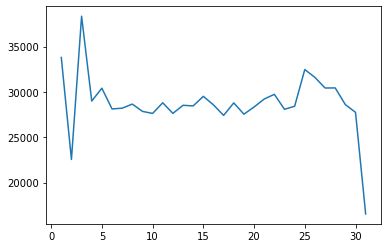

Identified inflection points are:
We found an inflection point on 2015-01-02 00:00:00 with streak value of 0. 2nd value is -25149.220000000005.
We found an inflection point on 2015-01-03 00:00:00 with streak value of 0. 2nd value is 10771.600000000006.
We found an inflection point on 2015-01-04 00:00:00 with streak value of 0. 2nd value is -3706.430000000004.
We found an inflection point on 2015-01-05 00:00:00 with streak value of 0. 2nd value is 2370.470000000001.
We found an inflection point on 2015-01-07 00:00:00 with streak value of 1. 2nd value is -1256.7799999999988.
We found an inflection point on 2015-01-08 00:00:00 with streak value of 0. 2nd value is 579.2400000000016.
We found an inflection point on 2015-01-10 00:00:00 with streak value of 1. 2nd value is -2343.1399999999994.
We found an inflection point on 2015-01-11 00:00:00 with streak value of 0. 2nd value is 2058.4199999999983.
We found an inflection point on 2015-01-12 00:00:00 with streak value of 0. 2nd value is -959

In [494]:
#Generate an analysis instance.
analysis = InflectionAnalysis("C:/Users/rg255/Downloads/Inflections.csv")

#Run a detection cycle with the forward approach on the partition all, and retrieve the inflection points.
analysis.detectInflections(approach = "forward",partition = "all")
inflections = analysis.inflections.copy()

#Look at panel_1 and credit, for Netflix in Jan 2015.
from matplotlib import pyplot as plt

netflix_test = rawData[(rawData.Merchant == "Netflix")&(rawData.FixedDate.dt.year==2015)&(
    rawData.FixedDate.dt.month==1)&(rawData.Panel == "PANEL_1")&(rawData.Type=="CREDIT")]
netflix_test = netflix_test[["Sales","FixedDate"]]
plt.plot(netflix_test.FixedDate.dt.day,netflix_test.Sales)
plt.show()

#Below the graph, print out the inflection points that were detected for this period.
filtered_inflections = list(filter(
        lambda x: (x.merchant == "Netflix" and x.date.year == 2015 and x.date.month == 1
                   and x.panel == "PANEL_1" and x.ttype == "CREDIT"), inflections))

print("Identified inflection points are:")
for i in filtered_inflections:
    print("We found an inflection point on {0} with streak value of {1}. 2nd value is {2}.".format(
        i.date,i.streak,i.secondDerivValue))    

The above shows that the forward algorithm identified 23 inflection points for Netflix in Jan 2015 for the dataset where type = "CREDIT" and panel = "PANEL_1." Here is a running summary of what the inflection points paint as a story:

- we switched to concave on 01/02/2015.
- we switched to convex on 01/03/2015.
- we switched to concave on 01/04/2015.
- we switched to convex on 01/05/2015.
- we switched to concave on 01/07/2015.
- we switched to convex on 01/08/2015.
- we switched to concave on 01/10/2015.
- we switched to convex on 01/11/2015.
- we switched to concave on 01/12/2015.
- we switched to convex on 01/13/2015.
- we switched to concave on 01/14/2015.
- we switched to convex on 01/16/2015.
- we switched to concave on 01/17/2015.
- we switched to convex on 01/18/2015.
- we switched to concave on 01/20/2015.
- we switched to convex on 01/22/2015.
- we switched to concave on 01/24/2015.
- we switched to convex on 01/26/2015.
- we switched to concave on 01/27/2015.
- we switched to convex on 01/28/2015.
- we switched to concave on 01/29/2015.
- we switched to convex on 01/30/2015.
- we switched to concave on 01/31/2015.

This seems to approximate well what is happening during this period for Netflix, though it might report too many inflection points (more on why this is so later). As another example, suppose we take the same merchant and the same period of time and use the 3point method as well.

<ipython-input-487-5f1a3e347ebc>:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["NewIndex"] = newIndex
<ipython-input-487-5f1a3e347ebc>:327: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  D1_aux = pd.Series()
<ipython-input-487-5f1a3e347ebc>:342: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  secondDerivatives = pd.Series()


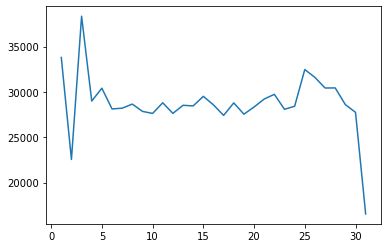

Identified inflection points are:
We found an inflection point on 2015-01-05 00:00:00 with streak value of 1. 2nd value is 1432.3024999999998.
We found an inflection point on 2015-01-08 00:00:00 with streak value of 2. 2nd value is -391.0599999999995.
We found an inflection point on 2015-01-09 00:00:00 with streak value of 0. 2nd value is 325.46750000000065.
We found an inflection point on 2015-01-11 00:00:00 with streak value of 1. 2nd value is -306.9225000000006.
We found an inflection point on 2015-01-12 00:00:00 with streak value of 0. 2nd value is 203.48250000000007.
We found an inflection point on 2015-01-14 00:00:00 with streak value of 1. 2nd value is -176.83250000000044.
We found an inflection point on 2015-01-16 00:00:00 with streak value of 1. 2nd value is 26.670000000000982.
We found an inflection point on 2015-01-18 00:00:00 with streak value of 1. 2nd value is -167.9925000000012.
We found an inflection point on 2015-01-19 00:00:00 with streak value of 0. 2nd value is 385.

In [495]:
#Run a detection cycle with the forward approach on the partition all, and retrieve the inflection points.
analysis.detectInflections(approach = "3point",partition = "all")
inflections = analysis.inflections.copy()

#Look at panel_1 and credit, for Netflix in Jan 2015.
from matplotlib import pyplot as plt

netflix_test = rawData[(rawData.Merchant == "Netflix")&(rawData.FixedDate.dt.year==2015)&(
    rawData.FixedDate.dt.month==1)&(rawData.Panel == "PANEL_1")&(rawData.Type=="CREDIT")]
netflix_test = netflix_test[["Sales","FixedDate"]]
plt.plot(netflix_test.FixedDate.dt.day,netflix_test.Sales)
plt.show()

#Below the graph, print out the inflection points that were detected for this period.
filtered_inflections = list(filter(
        lambda x: (x.merchant == "Netflix" and x.date.year == 2015 and x.date.month == 1
                   and x.panel == "PANEL_1" and x.ttype == "CREDIT"), inflections))

print("Identified inflection points are:")
for i in filtered_inflections:
    print("We found an inflection point on {0} with streak value of {1}. 2nd value is {2}.".format(
        i.date,i.streak,i.secondDerivValue))   

Considering the 3point approach, we can see that 15 inflection points are reported. The following story told for this interval by the 3point method is:

- we switched to convex on 01/05/2015.
- we switched to concave on 01/08/2015.
- we switched to convex on 01/09/2015.
- we switched to concave on 01/11/2015.
- we switched to convex on 01/12/2015.
- we switched to concave on 01/14/2015.
- we switched to convex on 01/16/2015.
- we switched to concave on 01/18/2015.
- we switched to convex on 01/19/2015.
- we switched to concave on 01/21/2015.
- we switched to convex on 01/23/2015.
- we switched to concave on 01/25/2015.
- we switched to convex on 01/27/2015.
- we switched to concave on 01/28/2015.
- we switched to convex on 01/30/2015.

This is similar to the forward approach, but it misses several of the inflection points in the beginning of the interval. This is the nature of the 3point method: because it requires a value before and after, it throws out one extra point compared to the forward method.

After some basic sanity tests, it appears as though our code is approximating the inflection points that exist in the data.

## Inflection "Streaks"

One thing we want to consider is how sudden an inflection point is. One way that we can determine this is to examine for how many days it took for the second derivative to change sign. We can capture this with the idea of an **inflection streak**. The code that we wrote above keeps track of how many days it took for the sign to change. The longer the streak, the more likely the inflection point was gradual or phased. On the other hand, if the inflection streak is small, it means that the inflection point occurred more suddenly. So we should capture this information, if we can.

The below is some code that will run all of the various partition and approach permutations, and will aggregate the results together. We are capturing the following derived fields:

- the number of inflection points recorded,
- the average streak length for inflection points, and
- the max streak length for inflection points.

In [501]:
#Function for analyzing inflection points.
def CalculateInflectionStatistics(inflections,analysisObject):
    d = {}
    
    merchants = set(analysisObject.merchants)
    panels = set(analysisObject.panels) | set(["Not Applicable"])
    types = set(analysisObject.ttypes) | set(["Not Applicable"])
    
    for m in analysisObject.merchants:
        for p in panels:
            for t in types:
                inflectionTotal = 0
                maxInflectionStreak = 0
                inflectionStreakSum = 0
                for i in filter(lambda x: x.merchant == m and x.ttype == t and x.panel == p,inflections):
                    inflectionTotal += 1
                    inflectionStreakSum += i.streak
                    if i.streak > maxInflectionStreak:
                        maxInflectionStreak = i.streak
                    key = m + '-' + p + '-' + t
                    d[key] = (
                        inflectionTotal,
                        maxInflectionStreak,
                        inflectionStreakSum/inflectionTotal if inflectionTotal > 0 else -1
                    )
    return d
            
analysis = InflectionAnalysis("C:/Users/rg255/Downloads/Inflections.csv")
allResults = []

#Forward
analysis.detectInflections(approach = "forward",partition = "panel")        
forward_panel_inflections = analysis.inflections.copy()
forward_panel_results = CalculateInflectionStatistics(forward_panel_inflections,analysis)
allResults.append(("forward-panel",forward_panel_results))

analysis.detectInflections(approach = "forward",partition = "ttype")        
forward_ttype_inflections = analysis.inflections.copy()
forward_ttype_results = CalculateInflectionStatistics(forward_ttype_inflections,analysis)
allResults.append(("forward-ttype",forward_ttype_results))

analysis.detectInflections(approach = "forward",partition = "all")        
forward_all_inflections = analysis.inflections.copy()
forward_all_results = CalculateInflectionStatistics(forward_all_inflections,analysis)
allResults.append(("forward-all",forward_all_results))

analysis.detectInflections(approach = "forward",partition = "none")        
forward_none_inflections = analysis.inflections.copy()
forward_none_results = CalculateInflectionStatistics(forward_none_inflections,analysis)
allResults.append(("forward-none",forward_none_results))

#Backward
analysis.detectInflections(approach = "backward",partition = "panel")        
backward_panel_inflections = analysis.inflections.copy()
backward_panel_results = CalculateInflectionStatistics(backward_panel_inflections,analysis)
allResults.append(("backward-panel",backward_panel_results))

analysis.detectInflections(approach = "backward",partition = "ttype")        
backward_ttype_inflections = analysis.inflections.copy()
backward_ttype_results = CalculateInflectionStatistics(backward_ttype_inflections,analysis)
allResults.append(("backward-ttype",backward_ttype_results))

analysis.detectInflections(approach = "backward",partition = "all")        
backward_all_inflections = analysis.inflections.copy()
backward_all_results = CalculateInflectionStatistics(backward_all_inflections,analysis)
allResults.append(("backward-all",backward_all_results))

analysis.detectInflections(approach = "backward",partition = "none")        
backward_none_inflections = analysis.inflections.copy()
backward_none_results = CalculateInflectionStatistics(backward_none_inflections,analysis)
allResults.append(("backward-none",backward_none_results))

#3point
analysis.detectInflections(approach = "3point",partition = "panel")        
threePoint_panel_inflections = analysis.inflections.copy()
threePoint_panel_results = CalculateInflectionStatistics(threePoint_panel_inflections,analysis)
allResults.append(("3point-panel",threePoint_panel_results))

analysis.detectInflections(approach = "3point",partition = "ttype")
threePoint_ttype_inflections = analysis.inflections.copy()
threePoint_ttype_results = CalculateInflectionStatistics(threePoint_ttype_inflections,analysis)
allResults.append(("3point-ttype",threePoint_ttype_results))

analysis.detectInflections(approach = "3point",partition = "all")
threePoint_all_inflections = analysis.inflections.copy()
threePoint_all_results = CalculateInflectionStatistics(threePoint_all_inflections,analysis)
allResults.append(("3point-all",threePoint_all_results))

analysis.detectInflections(approach = "3point",partition = "none")
threePoint_none_inflections = analysis.inflections.copy()
threePoint_none_results = CalculateInflectionStatistics(threePoint_none_inflections,analysis)
allResults.append(("3point-none",threePoint_none_results))

#5point
analysis.detectInflections(approach = "5point",partition = "panel")        
fivePoint_panel_inflections = analysis.inflections.copy()
fivePoint_panel_results = CalculateInflectionStatistics(fivePoint_panel_inflections,analysis)
allResults.append(("5point-panel",fivePoint_panel_results))

analysis.detectInflections(approach = "5point",partition = "ttype")
fivePoint_ttype_inflections = analysis.inflections.copy()
fivePoint_ttype_results = CalculateInflectionStatistics(fivePoint_ttype_inflections,analysis)
allResults.append(("5point-ttype",fivePoint_ttype_results))

analysis.detectInflections(approach = "5point",partition = "all")
fivePoint_all_inflections = analysis.inflections.copy()
fivePoint_all_results = CalculateInflectionStatistics(fivePoint_all_inflections,analysis)
allResults.append(("5point-all",fivePoint_all_results))

analysis.detectInflections(approach = "5point",partition = "none")
fivePoint_none_inflections = analysis.inflections.copy()
fivePoint_none_results = CalculateInflectionStatistics(fivePoint_none_inflections,analysis)
allResults.append(("5point-none",fivePoint_none_results))    

<ipython-input-487-5f1a3e347ebc>:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["NewIndex"] = newIndex
<ipython-input-487-5f1a3e347ebc>:185: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  D1_aux = pd.Series()
<ipython-input-487-5f1a3e347ebc>:200: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  secondDerivatives = pd.Series()
<ipython-input-487-5f1a3e347ebc>:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Let's examine the results to ensure that our code is capturing every possible permutation. Recall that we had 900 cases. Let's confirm that there are 900 elements:

In [509]:
#Iterate through all results, and print out how many there were for that permutation.
print("The below will tell us how many results there are for the choice of <approach-partition>.")
print("------------------------------------------------------------------------------------------")
total = 0
for i in allResults:
    print("For the choice of <{0}> we have: {1} elements.".format(i[0],len(i[1])))
    total += len(i[1])
print("------------------------------------------------------------------------------------------")
print("We have a grand total of {0} cases.".format(total))

The below will tell us how many results there are for the choice of <approach-partition>.
------------------------------------------------------------------------------------------
For the choice of <forward-panel> we have: 50 elements.
For the choice of <forward-ttype> we have: 50 elements.
For the choice of <forward-all> we have: 100 elements.
For the choice of <forward-none> we have: 25 elements.
For the choice of <backward-panel> we have: 50 elements.
For the choice of <backward-ttype> we have: 50 elements.
For the choice of <backward-all> we have: 100 elements.
For the choice of <backward-none> we have: 25 elements.
For the choice of <3point-panel> we have: 50 elements.
For the choice of <3point-ttype> we have: 50 elements.
For the choice of <3point-all> we have: 100 elements.
For the choice of <3point-none> we have: 25 elements.
For the choice of <5point-panel> we have: 50 elements.
For the choice of <5point-ttype> we have: 50 elements.
For the choice of <5point-all> we have: 100

In [510]:
print(allResults)

[('forward-panel', {'AutoZone-PANEL_2-Not Applicable': (1236, 5, 0.4749190938511327), 'AutoZone-PANEL_1-Not Applicable': (1212, 4, 0.5041254125412541), "BJ's Ex Fuel-PANEL_2-Not Applicable": (1068, 5, 0.7069288389513109), "BJ's Ex Fuel-PANEL_1-Not Applicable": (1004, 4, 0.8157370517928287), 'Canada Goose-PANEL_2-Not Applicable': (722, 4, 0.3878116343490305), 'Canada Goose-PANEL_1-Not Applicable': (448, 5, 0.33705357142857145), 'Dollar General-PANEL_2-Not Applicable': (945, 5, 0.928042328042328), 'Dollar General-PANEL_1-Not Applicable': (1315, 3, 0.3855513307984791), "Domino's Pizza-PANEL_2-Not Applicable": (742, 4, 1.4568733153638813), "Domino's Pizza-PANEL_1-Not Applicable": (1132, 3, 0.6104240282685512), "Kohl's-PANEL_2-Not Applicable": (1026, 5, 0.776803118908382), "Kohl's-PANEL_1-Not Applicable": (1109, 4, 0.6420198376916141), 'Lyft-PANEL_2-Not Applicable': (624, 5, 1.921474358974359), 'Lyft-PANEL_1-Not Applicable': (962, 4, 0.895010395010395), "Macy's-PANEL_2-Not Applicable": (120

Excellent! Now let's consolidate all of the cases into a single dataframe for easy reading.

In [511]:
colNames = ["Approach","Partition","Merchant","Panel","Type","NumInflections",
            "MaxInflectionStreak","AvgInflectionStreak"]
rows = []

for entry in allResults:
    left = entry[0]
    d = entry[1]
    approach = left[0:left.find('-')]
    partition = left[left.find('-')+1:]
    for key in d.keys():
        k = key.split('-')
        merchant = k[0]
        panel = k[1]
        ttype = k[2]
        numInflections = d[key][0]
        maxStreak = d[key][1]
        avgStreak = d[key][2]
        rows.append([approach,partition,merchant,panel,ttype,
                     numInflections,maxStreak,avgStreak])
df = pd.DataFrame(rows,columns = colNames)
df.sort_values(by = ["Merchant","Approach","Partition"],inplace=True)
df

,Approach,Partition,Merchant,Panel,Type,NumInflections,MaxInflectionStreak,AvgInflectionStreak
550,3point,all,AutoZone,PANEL_2,DEBIT,591,4,2.077834
551,3point,all,AutoZone,PANEL_2,CREDIT,755,5,1.410596
552,3point,all,AutoZone,PANEL_1,DEBIT,647,5,1.814529
553,3point,all,AutoZone,PANEL_1,CREDIT,664,5,1.742470
650,3point,none,AutoZone,Not Applicable,Not Applicable,625,4,1.912000
...,...,...,...,...,...,...,...,...
224,forward,none,Wix.com,Not Applicable,Not Applicable,1327,4,0.373022
48,forward,panel,Wix.com,PANEL_2,Not Applicable,1315,4,0.385551
49,forward,panel,Wix.com,PANEL_1,Not Applicable,1346,3,0.354383
98,forward,ttype,Wix.com,Not Applicable,DEBIT,1326,4,0.374811


Now that we have run our process through and collected data, we can look at how the various methods perform for each merchant. There are 25 merchants in the dataset, but we can restrict our analysis to a handful to get the gist as to how we should proceed. Let's start with AutoZone, the first merchant in our dataset.

In [521]:
#Get all the data for Autozone.
Autozone = df[df.Merchant == "AutoZone"]
Autozone[["Approach","Partition","Merchant","Panel","Type","NumInflections"]]

,Approach,Partition,Merchant,Panel,Type,NumInflections
550,3point,all,AutoZone,PANEL_2,DEBIT,591
551,3point,all,AutoZone,PANEL_2,CREDIT,755
552,3point,all,AutoZone,PANEL_1,DEBIT,647
553,3point,all,AutoZone,PANEL_1,CREDIT,664
650,3point,none,AutoZone,Not Applicable,Not Applicable,625
450,3point,panel,AutoZone,PANEL_2,Not Applicable,653
451,3point,panel,AutoZone,PANEL_1,Not Applicable,611
500,3point,ttype,AutoZone,Not Applicable,DEBIT,635
501,3point,ttype,AutoZone,Not Applicable,CREDIT,725
775,5point,all,AutoZone,PANEL_2,DEBIT,695


From the above, it is clear that the backward and forward methods perform identically, so there is no difference there. As for the 3point and 5point methods, it appears as though they report fewer inflections than the backward and forward algorithms overall, with 3point actually consistently reporting fewer than 5point. This makes some sense if one considers that the backward and forward algorithms is a rougher approximation to the first and second derivatives (i.e. the error is larger for these estimations than the error for 3point and 5point).

Let's check out another example: Netflix.

In [522]:
#Get all the data for Netflix.
Netflix = df[df.Merchant == "Netflix"]
Netflix[["Approach","Partition","Merchant","Panel","Type","NumInflections"]]

,Approach,Partition,Merchant,Panel,Type,NumInflections
586,3point,all,Netflix,PANEL_2,DEBIT,846
587,3point,all,Netflix,PANEL_2,CREDIT,884
588,3point,all,Netflix,PANEL_1,DEBIT,852
589,3point,all,Netflix,PANEL_1,CREDIT,872
659,3point,none,Netflix,Not Applicable,Not Applicable,862
468,3point,panel,Netflix,PANEL_2,Not Applicable,900
469,3point,panel,Netflix,PANEL_1,Not Applicable,838
518,3point,ttype,Netflix,Not Applicable,DEBIT,850
519,3point,ttype,Netflix,Not Applicable,CREDIT,880
811,5point,all,Netflix,PANEL_2,DEBIT,981


Once again, we see our general principles hold true here as well. That is:

- 3point and 5point report fewer inflections than backward and forward.
- backward and forward perform identically.
- 3point reports fewer inflection points than 5point.

Let's look at one more.

In [523]:
#Get all the data for Six Flags.
SixFlags = df[df.Merchant == "Six Flags"]
SixFlags[["Approach","Partition","Merchant","Panel","Type","NumInflections"]]

,Approach,Partition,Merchant,Panel,Type,NumInflections
606,3point,all,Six Flags,PANEL_2,DEBIT,706
607,3point,all,Six Flags,PANEL_2,CREDIT,683
608,3point,all,Six Flags,PANEL_1,DEBIT,709
609,3point,all,Six Flags,PANEL_1,CREDIT,729
664,3point,none,Six Flags,Not Applicable,Not Applicable,647
478,3point,panel,Six Flags,PANEL_2,Not Applicable,667
479,3point,panel,Six Flags,PANEL_1,Not Applicable,697
528,3point,ttype,Six Flags,Not Applicable,DEBIT,721
529,3point,ttype,Six Flags,Not Applicable,CREDIT,673
831,5point,all,Six Flags,PANEL_2,DEBIT,889


This further confirms the results we mentioned earlier.

What we are seeing here is that it seems as though the backward and forward approaches generally provide too many inflection points, and they likely overestimate the number of inflection points that there actually are. On the other hand, it is not clear which of the 3point and 5point methods are more reliable. Generally, the 5point tends to report more inflections, while the 3point tends to report fewer. 3point is less permissive than 5point.

As a general rule, the method that we should select depends on our risk preferences: if we attach a great weight to obtaining all of the inflection points even if it means false positives, then we should go with the 5point method. On the other hand, if we want to minimize the number of false positives, then it is better to go with the 3point method.

# Part 5: Final Conlusions and Future Considerations

## Recommendations

As promised, we need to provide a few solid recommendations for how to proceed and some leads as to how to carry this analysis further.

First, a word on which method to use in checking inflection points. From what we can see in the data, it appears as though the 3point and 5point methods should be selected over the backward and forward approaches. Whether we use the 3point or 5point approach depends on how permissive we want to be in selecting the inflection points. **If we want to err on the side of caution in reporting inflection points, then we should use the 3point method; otherwise, use the 5point method. This is our first decision.**

Next comes the question of whether we want to partition the data or not. This is a nontrivial decision, and I would suggest that we do it as a preliminary check. When we partition the data, we can see the _relative volatility_ of the subset of the data that is partitioned. The reason for this is that the number of inflection points is an indication of how unstable or volatile the data are. If we were to partition the data on say, Panel, and we saw PANEL_1 had far more inflection points reported than PANEL_2, it would say that PANEL_1 is more volatile than PANEL_2. **As such, partitioning can help us to isolate the volatility across factors in our original data.**

As a general rule, we can see that the number of inflection points reported for those cases where no partitioning is done is generally smaller than the number of inflection points reported for those cases where partitioning is done. The reason for this is that the different factors taken together are generally more stable (i.e. less volatile) over time, and therefore, we would expect there to be fewer inflection points. As a final guideline here, I would say that one should partition by panel and type to see whether we can isolate volatility in certain subsets of the data.

## Future Considerations

There are a few things that one can do to improve the work done in this case study to make the results more accurate.

First, one can help to eliminate false positives by looking at seasonality in the data. Seasonality is a large topic with many possibilities. There can be seasonality within a given week (i.e., sales on weekends or Fridays can be more or less than sales on weekdays), seasonality within a given month (i.e. the first week of the month may generally see more or less activity than the last week of the month), and seasonality within a given year (i.e., sales may be concentrated within a few months of the year, say October to December, and may wane in the summer, or vice versa).

A point worth mentioning with regards to seasonality and inflection points is that if one gets an inflection point that exists on a seasonal basis, this does not invalidate the fact that it is an inflection point. On the contrary, it is still an inflection point, but one might call it a _planned_ or _expected_ inflection point, as opposed to those inflection points that are unplanned and tied to certain "black swan" events.

Second, one can leverage the streak field that was stored in the Inflection class to get some idea as to how gradual an inflection point is in time. On its own it can tell us how long a sales curve remains concave or convex, but technically, one could still have a sudden change in concavity despite the regularity preceding the change. Hence, streak on its own is not so useful. However, if we combine the streak field with a running _percent change_ field for the second derivative, we may be able to arrive at a better metric for determining how gradual or sudden an inflection point is.

Overall, this is a complex task that can benefit from more attention.